# Mount Sinabung eruption as seen by Sentinel-5P

Thanks to Stefano Mattia for this. We elaborated around it to introduce additional elements and guidance.
Antefact: On February 19, 2018, Indonesia's Mount Sinabug, a stratovolcano on the island of Sumatra, erupted violently, spewing ash at least 5 to 7 kilometers into the air over Indonesia.  

The erupting lava dome obliterated a chunk of the peak as it erupted. Plumes of hot gas and ash rode down the volcano’s summit and spread out in a 5-kilometer diameter, coating surrounding villages in ash. 

In this post, we are going to see how this event has been recorded by the [TROPOMI](http://www.tropomi.eu) instrument on board of [ESA](http://www.esa.int)'s Sentinel-5P earth observation satellite, using Python, xarray, and cartopy.
This is a first example on how to use xarray to manipulate efficiently array datasets

## Environment configuration

Let's import our libraries

In [2]:
import numpy as np
import xarray as xr
import netCDF4 as nc
from glob import iglob
from os.path import join
from collections import namedtuple

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.colorbar import colorbar

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

Let's give our plot a bit more of a ESA look by using the ESA font:

In [2]:
# define font family for plots
rcParams['font.family'] = 'NotesEsa'

## Define plot extent

We are going to define our plot extent as square centered around the volcano.

In [3]:
Point = namedtuple('Point', 'lon lat')
sinabung_coords = Point(98.3930, 3.169)

extent_size = 4
plot_extent = (sinabung_coords.lon-extent_size, 
               sinabung_coords.lon+extent_size, 
               sinabung_coords.lat-extent_size, 
               sinabung_coords.lat+extent_size,)

print("Plot extent: lon({}, {}), lat({}, {})".format(*plot_extent))

Plot extent: lon(94.393, 102.393), lat(-0.831, 7.1690000000000005)


## Reading the data

My sample products are usually stored in a structured directory tree. The following line of code recursively looks for all files matching a given filename pattern starting from a root directory.

In [4]:
input_files_dir = "/Users/stefano/src/s5p/products/SO2_Sinabung/"
input_files = sorted(list(iglob(join(input_files_dir, '**', '*SO2*.nc'), recursive=True)))

for counter, input_file in enumerate(input_files):
    fields = input_file.split('_')
    print("#{} Orbit: {}, Sensing Start: {}, Sensing Stop: {}".format(counter, fields[11], fields[9], fields[10]))

#0 Orbit: 01814, Sensing Start: 20180218T054902, Sensing Stop: 20180218T073033
#1 Orbit: 01828, Sensing Start: 20180219T053006, Sensing Stop: 20180219T071137
#2 Orbit: 01842, Sensing Start: 20180220T051110, Sensing Stop: 20180220T065240
#3 Orbit: 01843, Sensing Start: 20180220T065240, Sensing Stop: 20180220T083411
#4 Orbit: 01857, Sensing Start: 20180221T063344, Sensing Stop: 20180221T081515
#5 Orbit: 01871, Sensing Start: 20180222T061448, Sensing Stop: 20180222T075618
#6 Orbit: 01885, Sensing Start: 20180223T055552, Sensing Stop: 20180223T073722


Product #1 seems to be covering the day of the eruption. Let's open it with xarray. I know in advance that the variable of interest (SO<sub>2</sub> total vertical column) is stored in the `PRODUCT` group, so all we have to do is:

In [5]:
so2tc = xr.open_dataset(input_files[1], group='/PRODUCT')['sulfurdioxide_total_vertical_column']
print(so2tc)

<xarray.DataArray 'sulfurdioxide_total_vertical_column' (time: 1, scanline: 3245, ground_pixel: 450)>
[1460250 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * ground_pixel  (ground_pixel) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * time          (time) datetime64[ns] 2018-02-19
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             total vertical col...
    multiplication_factor_to_convert_to_DU:                2241.15
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19


The advantage of storing our data into an xarray DataArray is being able to access xarray's amazing [indexing, filtering and masking](http://xarray.pydata.org/en/stable/indexing.html) capabilities, something that would require much more effort, should we limited to use the basic NetCDF4 libray instead.

## Processing the data

We would like to subset our dataset around our point of interest. To do so, we are going to define a function that takes an xarray's DataArray and latitude/longitude boundaries, and returns a _crop_ of the input dataset. The function relies on the xarray's filtering function `where`. Values outside the crop region will be discarded. We assume that both `latitude` and `longitude` are actual dimensions in our input dataset.

In [6]:
def subset(so2tc, plot_extent):
    e, w, s, n = plot_extent

    # crop data set around point of interest
    so2tc = so2tc.where(
        (so2tc.longitude > e) &
        (so2tc.longitude < w) &
        (so2tc.latitude > s) & 
        (so2tc.latitude < n), drop=True)

    return so2tc

In [7]:
so2tc = subset(so2tc, plot_extent)

Next, we are going to set all negative values to 0, as well as converting the values to Dobson Units.

In [8]:
# set all negative values to 0
so2tc = so2tc.where(so2tc > 0, 0)
# convert ALL values to DU
so2tc = so2tc * so2tc.multiplication_factor_to_convert_to_DU

Easy as pie! 

Our dataset is now ready to be plotted.

## Plotting the data

Let's define a custom color map, with increasing alpha (transparency) level.
The idea is that lower values should be more transparent than higher values, following a square root law. Doing so, we prevent lower background values to show up in the plot, and at the same time we emphasize the impact of higher values.

In [9]:
cm_values = np.linspace(0, 1, 16536)
# use the Yellow Orange Brown color map as reference
alpha_cm = plt.cm.YlOrBr(cm_values)
# change alpha value to follow a square low
alpha_cm[:, -1] = np.sqrt(cm_values)
# build new color map
my_cmap = colors.ListedColormap(alpha_cm)

For sake of convenience, we can define a function that is going to take care of plotting the dataset. We are going to use cartopy's ability to seamlessly add [Natural Earth Data](http://www.naturalearthdata.com) features to the plot. In this example, we are going to add state/province borders and land features.

I played a bit with adding Google map's tiles to the plot background but the results were suboptimal. I raised an [issue](https://github.com/SciTools/cartopy/issues/1048) on cartopy's github, which so far does not have any practical solution. That's a bit of a shame and I strongly hope that a solution comes up soon.  

Note that the actual SO<sub>2</sub> total vertical column plot is performed by the `pcolormesh` function. The rest is basically bells and whistles. Worthy of mention is the use of a custom colormap normalization, to follow a square root law. In this way, we avoid the higher values to overwhelmingly saturate the plot.

In [16]:
def plot_so2(so2tc):
    fig, ax = plt.subplots(figsize=(18, 12))

    ax = plt.axes(projection=ccrs.PlateCarree())

    # define Natural Earth features
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor='none')

    land_10m = cfeature.NaturalEarthFeature(
        category='physical', 
        name='land', 
        scale='10m',
        edgecolor='face',
        facecolor=cfeature.COLORS['land'])


    # set map background and features
    ax.add_feature(land_10m)
    ax.add_feature(states_provinces, edgecolor='lightgray')

    # define plot titles, subtitle and caption
    ax.text(0, 1.05, r"SO$_2$ total vertical column", fontsize=18, transform=ax.transAxes)
    ax.text(0, 1.02, r"Mount Sinabung, Indonesia, {}".format(str(so2tc.time.data[0]).split('T')[0]), 
            fontsize=14, transform=ax.transAxes)
    ax.text(0.57, -0.18, r"Data: ESA Sentinel-5P/TROPOMI, Map: Natural Earth Data", 
            fontsize=12, color='gray', transform=ax.transAxes)

    # set plot frame color
    ax.outline_patch.set_edgecolor('lightgray')

    # define plot extent
    ax.set_extent(plot_extent, ccrs.PlateCarree())

    # plot data
    im = so2tc.isel(time=0).plot.pcolormesh(ax=ax, 
                                            transform=ccrs.PlateCarree(),
                                            infer_intervals=True,
                                            cmap=my_cmap,
                                            norm=colors.PowerNorm(gamma=1./2.),
                                            vmin=0,
                                            #vmax=400,
                                            x='longitude', 
                                            y='latitude', 
                                            zorder=2)
    # plot mt. Sinabung 
    ax.plot(sinabung_coords.lon, sinabung_coords.lat, marker='^', 
            markeredgewidth=1, markeredgecolor='black',
            markerfacecolor='black', markersize=10)

    # remove side colorbar
    im.colorbar.remove()

    # remove default title
    ax.set_title('')

    # set colorbar properties
    cbar_ax = fig.add_axes([0.38, 0.05, 0.25, 0.01])
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=[0, 100, 200, 300, 400])
    cbar.set_label(r"SO$_2$ (Dobson Units)", labelpad=-50, fontsize=14)
    cbar.outline.set_visible(False)
    cbar.ax.set_yticklabels(['0', '100', '200', '300', '400'])

    # set gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.savefig("sinabung.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=2,
        frameon=None)
    plt.show()

Let's see it in action:

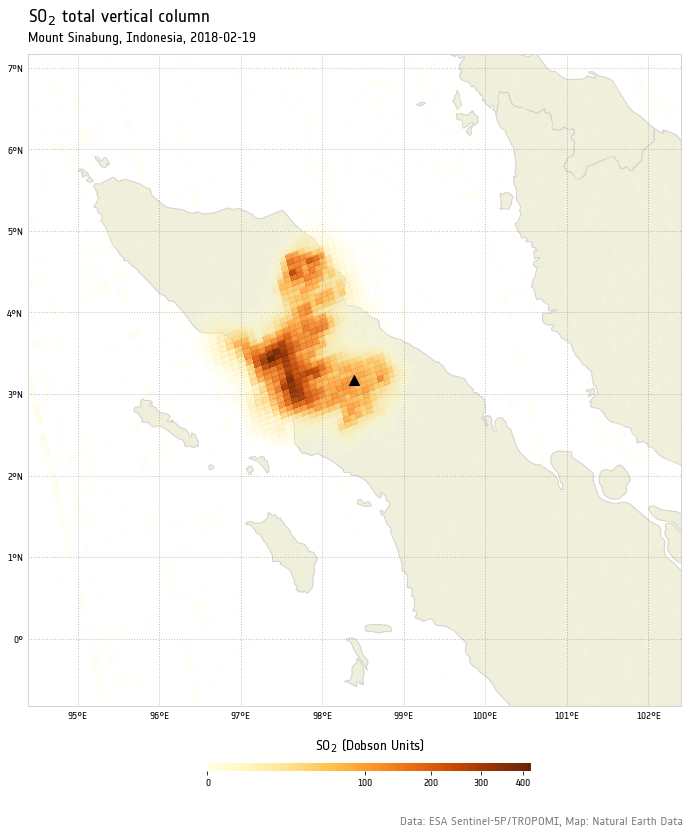

In [17]:
plot_so2(so2tc)

Look at that unprecedented resolution! 

For comparison, have a look at the same scene as seen by NASA's [VIIRS](https://earthobservatory.nasa.gov/IOTD/view.php?id=91753) instrument, and KNMI's [OMI](https://so2.gsfc.nasa.gov/pix/daily/ixxxza/loopall5pca_post17.php?yr=18&mo=02&dy=20&bn=sumatra) on board of NASA's Aura satellite.

## Conclusion

In this post, we showed how to use xarray to easily open and filter NetCDF4 files, and how craft a publication ready plot with Matplotlib and cartopy.

I hope you enjoyed it, and feel free to comment if you have questions or remarks (especially if you managed to properly display Google map's tiles in a cartopy plot!).

_This post was written entirely in a Jupyter notebook. You can download it on my [GitHub repository](https://github.com/stefanomattia/jupyter-notebooks/tree/master/earth-observation)._